In [2]:
# DONE remove stopwords, punctuation tags and number tags
# DONE Lematize
# DONE Tokenize
# DONE Word embeddings
# TODO Word2Vec


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
# from sklearn.model_selection import train_test_split
import numpy as np
import pickle
from glob import glob
import random
import os

In [4]:
tf.__version__
#print("hello")

'2.5.0-dev20210317'

In [5]:
import pandas as pd
import re
import pickle
import numpy as np
pd.set_option('display.max_colwidth', None)

##### Count words with stopwords and symbols

In [6]:
import spacy

# from spacy.tokenizer import Tokenizer
import utils
nlp = spacy.load('en_core_web_sm')
import en_core_web_sm


In [7]:
from spacy.lang.en.stop_words import STOP_WORDS
# (STOP_WORDS)

In [9]:
def read_from_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

data = read_from_pickle('/Users/karlestermann/PycharmProjects/ai_assignment_aidock/data/new_one_page_data_clean.pkl')

In [10]:
data.tail()

,paragraph,remove_stop_words,sent_count,num_count,clean_paragraph_len,verb_count,contains_pron,label
0,"1 pumpkin or large squash, (sugar pie pumpkin, butternut, buttercup or kabocha squash) Avoid large Halloween carving pumpkins because their flesh is too fibrous for a soft puree.",znum pumpkin large squash sugar pie pumpkin butternut buttercup kabocha squash avoid large halloween carve pumpkin pron flesh fibrous soft puree zdot,1,1,22,1,1,1
1,Chill until ready to use.,chill ready use zdot,1,0,4,2,0,0
2,"Preheat the oven to 400°F and line a baking sheet with parchment paper. Slice the squash in half, scoop out the seeds and place cut side down on the baking sheet.",preheat oven znum f line baking sheet parchment paper zdot slice squash half scoop seed place cut baking sheet zdot,2,1,20,2,0,0
3,"Roast for 40 to 60 minutes or until the flesh is soft and a fork easily slides in. Let cool for about 1 hour. Use your hands to peel the flesh from the skin and place in a food processor. Puree until smooth, letting your food processor run for about a minute, stopping to scrape down the sides as needed. If your puree is more watery than the texture of canned pumpkin, strain the excess liquid by letting it sit in a fine mesh strainer (or cheesecloth) over a bowl for 30 minutes.",roast znum znum minute flesh soft fork easily slide zdot let cool znum hour zdot use pron hand peel flesh skin place food processor zdot puree smooth let pron food processor run minute stopping scrape need zdot pron puree watery texture canned pumpkin strain excess liquid let pron sit fine mesh strainer cheesecloth bowl znum minute zdot znum,5,5,58,10,1,0


In [11]:
round(data['label'].value_counts()/len(data)*100,2)

0    75.0
1    25.0
Name: label, dtype: float64

In [17]:
train = pd.read_pickle('/Users/karlestermann/PycharmProjects/ai_assignment_aidock/data/new_train_data_clean.pkl')
round(train['label'].value_counts()/len(train)*100,2)

0    79.63
1    20.37
Name: label, dtype: float64

In [18]:
test = pd.read_pickle('/Users/karlestermann/PycharmProjects/ai_assignment_aidock/data/new_test_data_clean.pkl')
round(test['label'].value_counts()/len(test)*100,2)

0    79.65
1    20.35
Name: label, dtype: float64

In [19]:
maxSequenceLength_train = train['clean_paragraph_len'].max()#121 91-seed 42
maxSequenceLength_test = test['clean_paragraph_len'].max() #86 91-seed 42
maxSequenceLength_test, maxSequenceLength_train #(81, 91),

(217, 217)

In [20]:
#Sentences array for train and test sets + target variable for train and test
text_train = train['remove_stop_words']
y_train = train['label']

text_test = test['remove_stop_words']
y_test = test['label']

def get_max_sequence_len(series):
    max_words = 0
    for desc in series:
        words = len(desc.split())
        if words > max_words:
            max_words = words
    print(f'Max length in paragraph : {max_words} words')
    return max_words

max_sequence_length = get_max_sequence_len(text_train)#121
maxSequenceLength_test = get_max_sequence_len(text_test)#121
print(max_sequence_length,maxSequenceLength_test)
#(82, 121) --> max sent len in whole data is 121

Max length in paragraph : 217 words
Max length in paragraph : 217 words
217 217


### Tockenization of train set


In [21]:
max_sequence_length

217

In [ ]:
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(X_train)
# # top 15 max_count by wordsin our data
# tokenizer.word_counts
# sorted(tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True)[:15]

In [ ]:
# total_words = len(tokenizer.word_index)
# print(f'In vocab {total_words} words')
# #In vocab 2303 words

In [ ]:
# print(textSequences_train[:3])

In [22]:

def prep_text(texts, max_sequence_length):
    """ Create a union train set vocabulary and turn text in set
    into  padded sequences (word --> num )
    :param texts: series of prepared strings
           max_sequence_length: int max len of sentence in series
    :return ndArray with transformed series of text to int
            with 0-padding up to max_sequence_length"""
    # we will use only first most common 1000 words
    tokenizer1 = Tokenizer()
    tokenizer1.fit_on_texts(texts)
    vocab_size = len(tokenizer1.word_counts)

    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(texts)
    print('vocab len',vocab_size,len(tokenizer.word_index))
    # Turn text into  padded sequences (word --> num )
    text_sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(text_sequences, maxlen=max_sequence_length,
                         dtype="int32", padding="post", value=0), vocab_size




### Fot train set

In [23]:
sent2vec_train, vocab_size_train = prep_text(text_train, max_sequence_length)

# index_max_len_sent = train[train['clean_paragraph_len'] == max_sequence_length].index
# sent2vec_train[index_max_len_sent]

vocab len 2474 2474


In [24]:
# train[train['clean_paragraph_len'] == max_sequence_length]

In [25]:
print(sent2vec_train.shape)
print((train[['sent_count','num_count','clean_paragraph_len','contains_pron']].values).shape)

(3898, 217)
(3898, 4)


In [26]:
X_train = sent2vec_train #np.hstack((sent2vec_train, train[['sent_count','num_count','clean_paragraph_len','contains_pron']].to_numpy()))
y_train = train['label'].to_numpy().reshape(-1,1)

X_train.shape, y_train.shape


((3898, 217), (3898, 1))

### For test set

In [27]:
sent2vec_test, vocab_size_test = prep_text(text_test, maxSequenceLength_test)
# index_max_len_sent_test = test[test['clean_paragraph_len'] == maxSequenceLength_test].index #Int64Index([2373], dtype='int64')
# sent2vec_test[index_max_len_sent_test]

vocab len 1636 1636


In [28]:
X_test = sent2vec_test              #np.hstack((sent2vec_test, test[['sent_count','num_count','clean_paragraph_len','contains_pron']].to_numpy()))
y_test = test['label'].to_numpy().reshape(-1,1)

X_test.shape, y_test.shape


((973, 217), (973, 1))

In [29]:
# test[test['clean_paragraph_len'] == maxSequenceLength_test]

### Simple Neural Network

In [30]:
# NUM_WORDS=2000 # we will use
SEQ_LEN=121 # max len sequence
EMBEDDING_SIZE=128
BATCH_SIZE=128
EPOCHS=200
THRESHOLD=0.5


In [31]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size_train, EMBEDDING_SIZE),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dense(1, activation='sigmoid')])

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss'
          , mode='min')
callbacks=[es]
history = model.fit(X_train, y_train
                    , batch_size=BATCH_SIZE
                    , epochs=EPOCHS
                    , validation_data=(X_test, y_test)
                    , callbacks=callbacks)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         316672    
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 316,801
Trainable params: 316,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
31/31 [==============================] - 1s 15ms/step - loss: 0.6389 - accuracy: 0.7960 - val_loss: 0.5458 - val_accuracy: 0.7975

In [32]:
score = model.evaluate(X_test, y_test,
                       batch_size=BATCH_SIZE, verbose=1)
print()
print(u'Model Loss score: {}'.format(score[0]))
print(u'Model Accuracy Evaluation : {}'.format(score[1]))


8/8 [==============================] - 0s 2ms/step - loss: 0.5458 - accuracy: 0.7975

Model Loss score: 0.5457544326782227
Model Accuracy Evaluation : 0.797533392906189


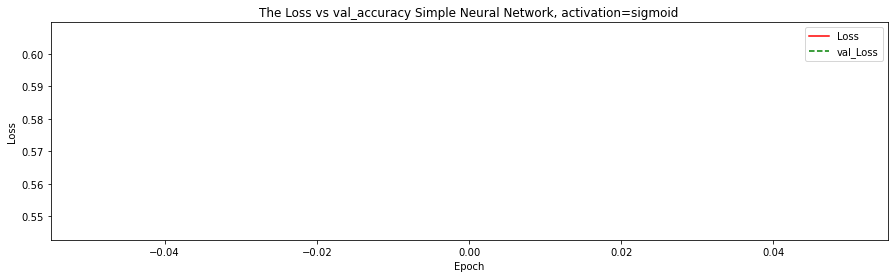

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore')
warnings.filterwarnings('ignore')

#plot the accuracy
plt.figure(figsize=(15,4))
plt.plot(history.history['loss'],'r', label='Loss')
plt.plot(history.history['val_loss'],'g--', label = 'val_Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0, 0.5])
# plt.xlim([0, 20])
plt.title('The Loss vs val_accuracy Simple Neural Network, activation=sigmoid')
plt.legend(loc='best');

In [34]:
THRESHOLD=0.5
preds = model.predict(X_test)

pred_df = pd.DataFrame(columns=['text', 'pred_label'])
pred_df['text'] = text_test
pred_df['pred_label'] = preds
pred_df['label'] = y_test
pred_df['label'] = pred_df['label'].apply(lambda x: 'Instructions' if x==0 else 'Recepie')
pred_df['pred_label'] = pred_df['pred_label'].apply(lambda x: 'Recepie' if x > THRESHOLD else 'Instructions')
pred_df[548:600]

,text,pred_label,label
548,medium bowl mix mango onion cilantro lime juice garlic jalape znum o salt zdot chill ready use zdot,Instructions,Instructions
549,add chopped chard leave macaroni noodle fennel frond continue simmer noodle cook zdot znum minute zdot,Instructions,Instructions
550,znum cup gin znum tablespoon meyer lemon juice znum tablespoon agave nectar splash ginger juice znum splash sparkle water lemon peel garnish,Instructions,Recepie
551,steamer basket pot simmer water steam carrot cover tender znum znum minute zdot remove set aside zdot steam broccoli tender bright green znum znum minute zdot lastly steam kale tender znum second znum minute zdot,Instructions,Instructions
552,small food processor combine egg yolks mayo yogurt relish mustard pulse smooth zdot season taste salt zdot,Instructions,Instructions
553,roast vegetable zdot place parsnip brussels sprout cauliflower large baking sheet zdot place broccolini second baking sheet zdot drizzle vegetable olive oil pinche salt pepper toss coat spread evenly sheet zdot roast parsnip znum brussels sprout znum cauliflower znum znum minute golden brown edge zdot roast broccolini znum znum minute tender zdot cool touch chop broccolini stem zdot,Instructions,Instructions
554,pour batter prepare pan use offset spatula gently smooth sure apple dispersed way edge pan zdot tap pan gently counter release air bubble zdot sprinkle remaining znum cup nut cake zdot,Instructions,Instructions
555,medium bowl whisk flour ground almond baking powder salt zdot,Instructions,Instructions
556,taste add salt pepper lemon juice taste zdot pron salad little dry drizzle olive oil toss zdot,Instructions,Instructions
557,znum tablespoon extra virgin olive oil znum small onion chop znum carrot chop znum tablespoon finely chop rosemary znum garlic clove mince znum medium roma vine tomato dice znum teaspoon red pepper flake znum tablespoon white wine znum cup cook cannellini bean drain rinse znum cup vegetable broth znum large lacinato kale leave thinly slice coarse stem remove znum thick slice stale ciabatta bread cube balsamic vinegar drizzle znum cup shave parmesan cheese optional sea salt freshly ground black pepper,Instructions,Recepie


In [35]:
model.save('/Users/karlestermann/PycharmProjects/ai_assignment_aidock/data/simpleNN_model.h5')

### LSTM

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM

# max count word to analize
# max_features = len(X_train)
# NUM_WORDS=2000 # we will use
SEQ_LEN=121 # max len sequence
EMBEDDING_SIZE=256
BATCH_SIZE=128
EPOCHS=200
THRESHOLD=0.5

print(u'Collecting the model')
lstm = Sequential()
lstm.add(Embedding(vocab_size_train, EMBEDDING_SIZE, mask_zero=True))
lstm.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))
lstm.add(Dense(1, activation='relu'))

lstm.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print (lstm.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 256)         633344    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                82176     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 715,585
Trainable params: 715,585
Non-trainable params: 0
_________________________________________________________________
None


In [37]:

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss'
          , mode='min')
callbacks=[es]

print(u'Model training')
history = model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=100,
          validation_split=0.2,
          callbacks=callbacks)


Model training
Epoch 1/100
25/25 [==============================] - 0s 13ms/step - loss: 0.4981 - accuracy: 0.7970 - val_loss: 0.4601 - val_accuracy: 0.8013


In [38]:
score = model.evaluate(X_test, y_test,
                       batch_size=BATCH_SIZE, verbose=1)
print()
print(u'Model Loss score: {}'.format(score[0]))
print(u'Model Accuracy Evaluation : {}'.format(score[1]))


8/8 [==============================] - 0s 3ms/step - loss: 0.4727 - accuracy: 0.7975

Model Loss score: 0.47268185019493103
Model Accuracy Evaluation : 0.797533392906189


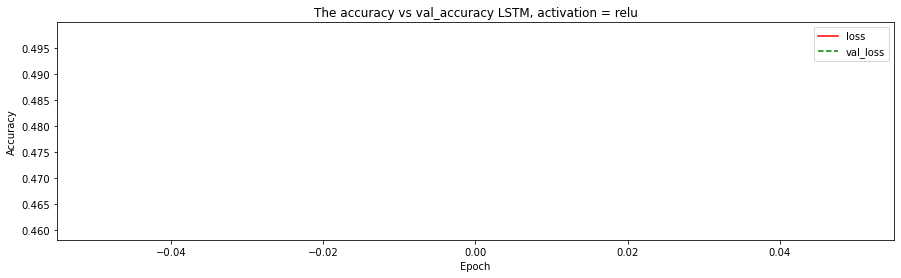

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore')
warnings.filterwarnings('ignore')

#plot the accuracy
plt.figure(figsize=(15,4))
plt.plot(history.history['loss'],'r', label='loss')
plt.plot(history.history['val_loss'],'g--', label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0, 0.5])
# plt.xlim([0, 20])
plt.title('The accuracy vs val_accuracy LSTM, activation = relu')
plt.legend(loc='best');

In [40]:
THRESHOLD=0.5
preds = model.predict(X_test)

pred_df = pd.DataFrame(columns=['text', 'pred_label'])
pred_df['text'] = text_test
pred_df['pred_label'] = preds
pred_df['label'] = y_test
pred_df['label'] = pred_df['label'].apply(lambda x: 'Instructions' if x==0 else 'Recepie')
pred_df['pred_label'] = pred_df['pred_label'].apply(lambda x: 'Recepie' if x > THRESHOLD else 'Instructions')
pred_df[548:600]

,text,pred_label,label
548,medium bowl mix mango onion cilantro lime juice garlic jalape znum o salt zdot chill ready use zdot,Instructions,Instructions
549,add chopped chard leave macaroni noodle fennel frond continue simmer noodle cook zdot znum minute zdot,Instructions,Instructions
550,znum cup gin znum tablespoon meyer lemon juice znum tablespoon agave nectar splash ginger juice znum splash sparkle water lemon peel garnish,Instructions,Recepie
551,steamer basket pot simmer water steam carrot cover tender znum znum minute zdot remove set aside zdot steam broccoli tender bright green znum znum minute zdot lastly steam kale tender znum second znum minute zdot,Instructions,Instructions
552,small food processor combine egg yolks mayo yogurt relish mustard pulse smooth zdot season taste salt zdot,Instructions,Instructions
553,roast vegetable zdot place parsnip brussels sprout cauliflower large baking sheet zdot place broccolini second baking sheet zdot drizzle vegetable olive oil pinche salt pepper toss coat spread evenly sheet zdot roast parsnip znum brussels sprout znum cauliflower znum znum minute golden brown edge zdot roast broccolini znum znum minute tender zdot cool touch chop broccolini stem zdot,Instructions,Instructions
554,pour batter prepare pan use offset spatula gently smooth sure apple dispersed way edge pan zdot tap pan gently counter release air bubble zdot sprinkle remaining znum cup nut cake zdot,Instructions,Instructions
555,medium bowl whisk flour ground almond baking powder salt zdot,Instructions,Instructions
556,taste add salt pepper lemon juice taste zdot pron salad little dry drizzle olive oil toss zdot,Instructions,Instructions
557,znum tablespoon extra virgin olive oil znum small onion chop znum carrot chop znum tablespoon finely chop rosemary znum garlic clove mince znum medium roma vine tomato dice znum teaspoon red pepper flake znum tablespoon white wine znum cup cook cannellini bean drain rinse znum cup vegetable broth znum large lacinato kale leave thinly slice coarse stem remove znum thick slice stale ciabatta bread cube balsamic vinegar drizzle znum cup shave parmesan cheese optional sea salt freshly ground black pepper,Instructions,Recepie


In [41]:
model.save('/Users/karlestermann/PycharmProjects/ai_assignment_aidock/data/simplelstm.h5')